<a href="https://colab.research.google.com/github/yecatstevir/teambrainiac/blob/main/source/SingleSubjSVM_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Analysis and Visualization of Single Subject SVM
-This notebook will summarize statistics for Single Subject SVM
-Create boxplots to look at spread of data

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')#, force_remount = True)

Mounted at /content/gdrive


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Clone the entire repo.
!git clone -l -s https://github.com/yecatstevir/teambrainiac.git
# Change directory into cloned repo
%cd teambrainiac/source
!ls

Cloning into 'teambrainiac'...
remote: Enumerating objects: 2113, done.
remote: Counting objects: 100% (298/298), done.
remote: Compressing objects: 100% (137/137), done.
remote: Total 2113 (delta 175), reused 271 (delta 161), pack-reused 1815
Receiving objects: 100% (2113/2113), 148.70 MiB | 11.95 MiB/s, done.
Resolving deltas: 100% (1366/1366), done.
/content/teambrainiac/source
access_data.py			    process.py
brain_viz_single_subj.py	    single_subject.py
BuildSingleSubjectSVM_Models.ipynb  SingleSubjectSVM.ipynb
data				    SingleSubjSVM_Analysis.ipynb
DL				    streamlit
group_svm			    utils.py
helper				    VisualizationPlayground.ipynb
__init__.py			    VisualizationsNotebook.ipynb


In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving path_config.py to path_config.py
User uploaded file "path_config.py" with length 228 bytes


In [5]:
# Import libraries
!pip install boto3 nilearn nibabel
#to load data
import pickle
#common packages we need
import numpy as np
import pandas as pd
#for brain imaging
import nibabel as nib
from nilearn import plotting, image
#for making graphs
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
%matplotlib inline
import seaborn as sns
from nilearn.image import threshold_img
#sklearn packages needed
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,auc,roc_auc_score,precision_recall_curve,precision_score,recall_score
from sklearn.svm import SVC
#import code for processing and visualizing data
from single_subject import *
from access_data import *
from brain_viz_single_subj import *

     |████████████████████████████████| 132 kB 4.3 MB/s 
     |████████████████████████████████| 9.6 MB 16.8 MB/s 
     |████████████████████████████████| 8.7 MB 55.2 MB/s 
     |████████████████████████████████| 79 kB 8.1 MB/s 
     |████████████████████████████████| 138 kB 71.0 MB/s 
     |████████████████████████████████| 38.1 MB 294 kB/s 
     |████████████████████████████████| 127 kB 78.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 r

In [6]:
#get common variables we need across multiple cells
data_path_dict = get_data_dict()
subj_ids, _ = get_subj_information(data_path_dict)
_ , y_test,_= get_labels(data_path_dict)
##get brain images
affine_image,t1_image,mni_image = get_brain_templates()

In [7]:
##setting mask list
#masks we want to grab data on, needs to be nested list for cell to run
#indices of the masks we want 0 = whole brain mask and masks minus ROIs, 1 = ROIs
mask_indices = [0,1]
mask_list = []
for ind in mask_indices:
  mask_dict = get_mask_data(data_path_dict,ind)  
  masks = list(mask_dict.keys())[3:]
  mask_list.append(masks)
# Example of building your own
# mask_dict = get_mask_data(data_path_dict,0)
# mask_list = [['mask']]
# mask_list_small = [['mask'],mask_list[1]]
# mask_list_small

[['mask'], ['acc_aal', 'anterior_insula_aal', 'mPFC', 'nacc_aal']]

In [8]:
#grab results
data_paths = []
for mask_ind in mask_indices:
  for mask in mask_list[mask_ind]:
    data_paths.append(f'/content/drive/My Drive/data/singlesubjectmodels/TR_2_TE_3_4/{mask}_tr_1_2_subject_models.pkl')

In [9]:
from sklearn import metrics
metrics_list = []
inc_trials = np.where(y_test==1)
dec_trials = np.where(y_test==0)
for data_path in data_paths:
  data = open_pickle(data_path)
  mask = list(data.keys())[0]
  subj_data = data[mask]
  for subj_id in subj_ids:
    subj_predicts = subj_data[subj_id]['predicts']
    if subj_id[0] == '1':
      group = 'Adolescent'
    else:
      group = 'Young Adult'
    for run in list(subj_predicts.keys()):
      subjs_acc_list = [mask,group,subj_id]
      subjs_acc_list.append(run)
      subjs_acc_list.append(accuracy_score(y_test,subj_predicts[run]['predicts'])) #get accuracy score
      subjs_acc_list.append(accuracy_score(y_test[inc_trials],subj_predicts[run]['predicts'][inc_trials])) #get sensitivity (same as recall tp/(tp+fn))
      subjs_acc_list.append(accuracy_score(y_test[dec_trials],subj_predicts[run]['predicts'][dec_trials])) #get specificity (tn/(tn+fp))
      subjs_acc_list.append(precision_score(y_test,subj_predicts[run]['predicts'])) #get precision scores (tp/(tp+fp))
      subjs_acc_list.append(recall_score(y_test,subj_predicts[run]['predicts'])) #get recall scores (tp/(tp+fn))
      subjs_acc_list.append(roc_auc_score(y_test,subj_predicts[run]['proba'][:,1])) #get auc score for positive class
      print(subjs_acc_list) #print
      metrics_list.append(subjs_acc_list) #append to list for further analysis
  #create individual mask df
  mask_df = pd.DataFrame(metrics_list,columns=['Mask Type','Group','Subject','Run','Accuracy','Sensitivity','Specificity','Precision','Recall','AUC Positive Class'])
  #save file
  mask_df.to_csv(f'/content/drive/My Drive/data/singlesubjectmodels/TR_2_TE_3_4/metrics_{mask}_tr_2_te3_4.csv')
#create dataframe from list
metrics_df = pd.DataFrame(metrics_list,columns=['Mask Type','Group','Subject','Run','Accuracy','Sensitivity','Specificity','Precision','Recall','AUC Positive Class'])
#savefile
metrics_df.to_csv('/content/drive/My Drive/data/singlesubjectmodels/metrics_allmask_tr_2_te3_4.csv')

['mask', 'Adolescent', '10004_08693', 'run_03', 0.7023809523809523, 0.6428571428571429, 0.7619047619047619, 0.7297297297297297, 0.6428571428571429, 0.7692743764172335]
['mask', 'Adolescent', '10004_08693', 'run_04', 0.8333333333333334, 0.8095238095238095, 0.8571428571428571, 0.85, 0.8095238095238095, 0.8928571428571428]
['mask', 'Adolescent', '10008_09924', 'run_03', 0.6309523809523809, 0.6666666666666666, 0.5952380952380952, 0.6222222222222222, 0.6666666666666666, 0.7312925170068028]
['mask', 'Adolescent', '10008_09924', 'run_04', 0.7261904761904762, 0.6666666666666666, 0.7857142857142857, 0.7567567567567568, 0.6666666666666666, 0.7908163265306123]
['mask', 'Adolescent', '10009_08848', 'run_03', 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.9365079365079365]
['mask', 'Adolescent', '10009_08848', 'run_04', 0.7857142857142857, 0.7857142857142857, 0.7857142857142857, 0.7857142857142857, 0.7857142857142857, 0.8565759637188208]
['mask

In [11]:
#create summary tables
#create summary tables for all subjects
all_subjects_runs_combined = metrics_df.groupby(['Mask Type']).mean()
print(all_subjects_runs_combined)
all_subjects_runs_combined.to_csv('/content/drive/My Drive/data/singlesubjectmodels/TR_2_TE_3_4/summary_statistics/summary_stats_all_subjects_runs_combined_tr_2_te3_4.csv')

                     Accuracy  Sensitivity  Specificity  Precision    Recall  \
Mask Type                                                                      
acc_aal              0.640339     0.658883     0.621795   0.638786  0.658883   
anterior_insula_aal  0.585508     0.596841     0.574176   0.584113  0.596841   
mPFC                 0.590430     0.611264     0.569597   0.587778  0.611264   
mask                 0.701809     0.703068     0.700549   0.705419  0.703068   
masksubACC           0.703182     0.703526     0.702839   0.707224  0.703526   
masksubAI            0.702610     0.703984     0.701236   0.705965  0.703984   
masksubNAcc          0.702038     0.702839     0.701236   0.705890  0.702839   
masksubmPFC          0.702038     0.703068     0.701007   0.705684  0.703068   
nacc_aal             0.602221     0.608745     0.595696   0.603655  0.608745   

                     AUC Positive Class  
Mask Type                                
acc_aal                        0.69

In [12]:
#summary table by run on all subjects
all_subjects_by_runs = metrics_df.groupby(['Mask Type','Run']).mean()
print(all_subjects_by_runs)
all_subjects_by_runs.to_csv('/content/drive/My Drive/data/singlesubjectmodels/TR_2_TE_3_4/summary_statistics/summary_stats_all_subjects_by_runs_tr_2_te3_4.csv')

                            Accuracy  Sensitivity  Specificity  Precision  \
Mask Type           Run                                                     
acc_aal             run_03  0.679716     0.695055     0.664377   0.677705   
                    run_04  0.600962     0.622711     0.579212   0.599868   
anterior_insula_aal run_03  0.613553     0.632326     0.594780   0.610450   
                    run_04  0.557463     0.561355     0.553571   0.557775   
mPFC                run_03  0.611035     0.634615     0.587454   0.609068   
                    run_04  0.569826     0.587912     0.551740   0.566489   
mask                run_03  0.740156     0.740842     0.739469   0.745363   
                    run_04  0.663462     0.665293     0.661630   0.665475   
masksubACC          run_03  0.740842     0.739927     0.741758   0.747002   
                    run_04  0.665522     0.667125     0.663919   0.667446   
masksubAI           run_03  0.740842     0.742216     0.739469   0.745570   

In [13]:
# #summary table by group on runs combined
all_subjects_runs_combined_by_group = metrics_df.groupby(['Mask Type','Group']).mean()
print(all_subjects_runs_combined_by_group)
all_subjects_runs_combined_by_group.to_csv('/content/drive/My Drive/data/singlesubjectmodels/TR_2_TE_3_4/summary_statistics/summary_stats_runs_combined_by_group.csv')

                                 Accuracy  Sensitivity  Specificity  \
Mask Type           Group                                             
acc_aal             Adolescent   0.618146     0.646825     0.589466   
                    Young Adult  0.678885     0.679825     0.677945   
anterior_insula_aal Adolescent   0.576840     0.594156     0.559524   
                    Young Adult  0.600564     0.601504     0.599624   
mPFC                Adolescent   0.576299     0.594156     0.558442   
                    Young Adult  0.614975     0.640977     0.588972   
mask                Adolescent   0.676407     0.680375     0.672439   
                    Young Adult  0.745927     0.742481     0.749373   
masksubACC          Adolescent   0.677489     0.680736     0.674242   
                    Young Adult  0.747807     0.743108     0.752506   
masksubAI           Adolescent   0.677309     0.681457     0.673160   
                    Young Adult  0.746554     0.743108     0.750000   
masksu

In [14]:
# #summary table by group by runs
all_subjects_by_run_by_group = metrics_df.groupby(['Mask Type','Group','Run']).mean()
print(all_subjects_by_run_by_group)
all_subjects_by_run_by_group.to_csv('/content/drive/My Drive/data/singlesubjectmodels/TR_2_TE_3_4/summary_statistics/summary_stats_by_run_by_group.csv')

                                        Accuracy  Sensitivity  Specificity  \
Mask Type           Group       Run                                          
acc_aal             Adolescent  run_03  0.658730     0.683261     0.634199   
                                run_04  0.577561     0.610390     0.544733   
                    Young Adult run_03  0.716165     0.715539     0.716792   
                                run_04  0.641604     0.644110     0.639098   
anterior_insula_aal Adolescent  run_03  0.602092     0.626984     0.577201   
                                run_04  0.551587     0.561328     0.541847   
                    Young Adult run_03  0.633459     0.641604     0.625313   
                                run_04  0.567669     0.561404     0.573935   
mPFC                Adolescent  run_03  0.595599     0.614719     0.576479   
                                run_04  0.556999     0.573593     0.540404   
                    Young Adult run_03  0.637845     0.669173   

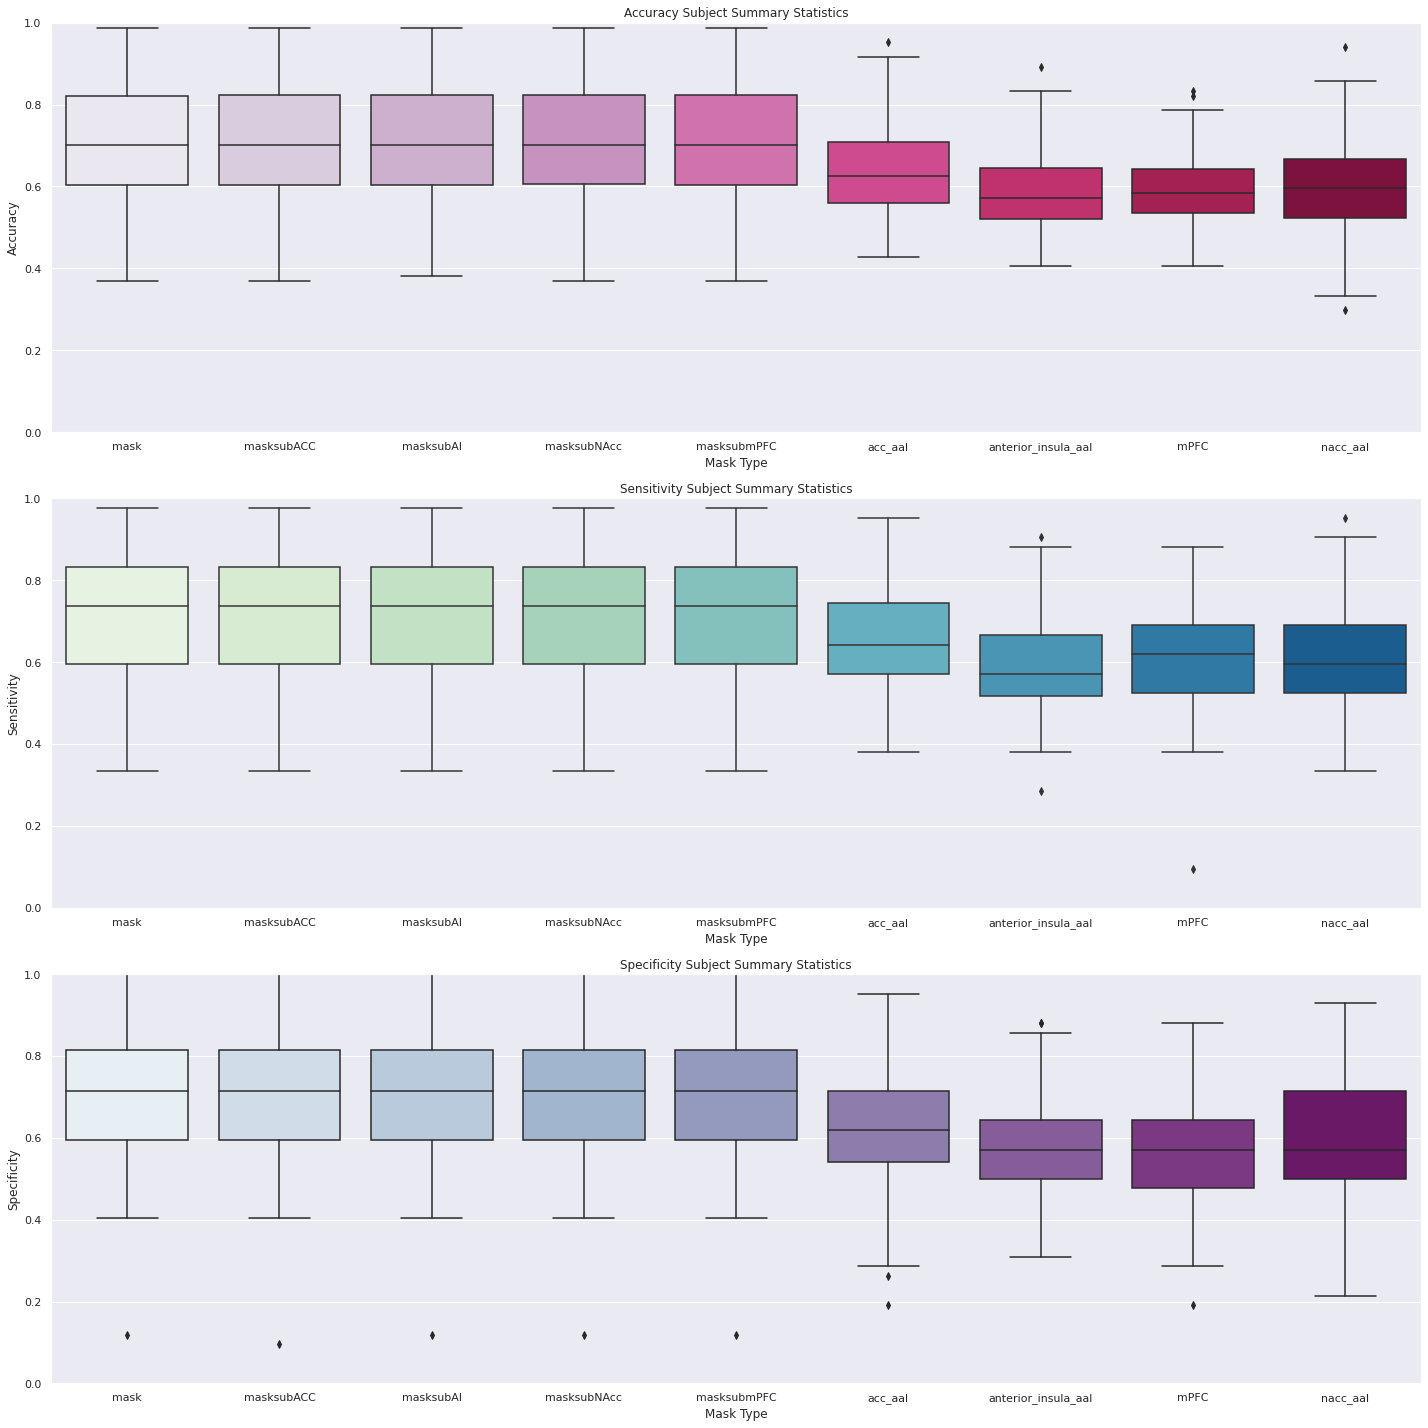

In [25]:
##create box plots accross all subjects runs combined
fig,axes=plt.subplots(3,1,figsize=(20,20)) #get figure size
fig.tight_layout() 
plt.style.use('seaborn-darkgrid')
sns.set(font_scale = 1)
column = 0
row = 0
runs_test = ['run_03','run_04']
metrics = ['Accuracy','Sensitivity','Specificity']
metrics = [('Accuracy','PuRd'),('Sensitivity','GnBu'),('Specificity','BuPu')]
for metric,color in metrics:
  sns.set(font_scale = 1)
  sns.boxplot(x='Mask Type',y=metric,data=metrics_df, ax=axes[row],palette=color) 
  axes[row].set_title(f'{metric} Subject Summary Statistics')
  axes[row].set_ylim(0,1)
  row +=1
fig.tight_layout()
fig.savefig('/content/drive/My Drive/data/singlesubjectmodels/TR_2_TE_3_4/box_plots/boxplot_tr_2runs3_4_combined.png',dpi=200)

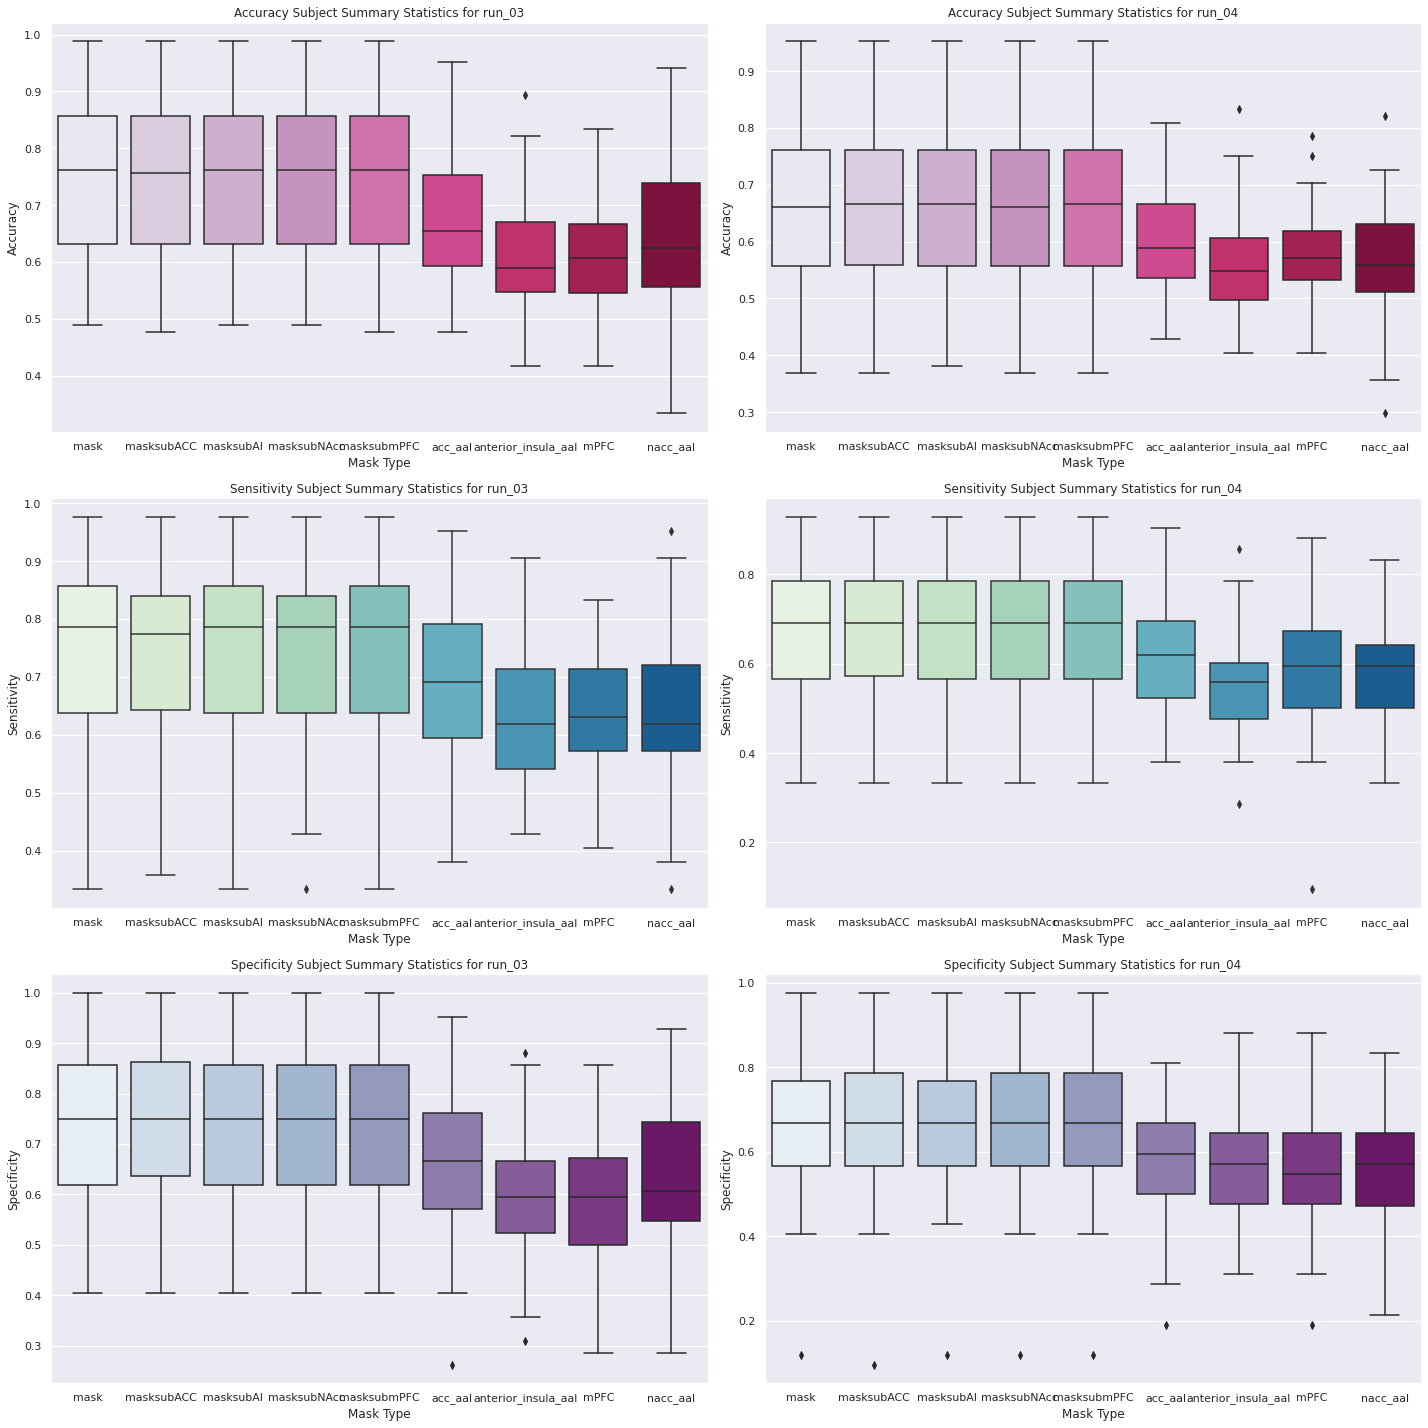

In [19]:
##create box plots accross all subjects by run
fig,axes=plt.subplots(3,2,figsize=(20,20)) #get figure size
fig.tight_layout() 
plt.style.use('seaborn-darkgrid')
sns.set(font_scale = 1)
column = 0
row = 0
runs_test = ['run_03','run_04']
metrics = ['Accuracy','Sensitivity','Specificity']
metrics = [('Accuracy','PuRd'),('Sensitivity','GnBu'),('Specificity','BuPu')]
for metric,color in metrics:
  for run in runs_test:
    df = metrics_df[metrics_df['Run']==run]
    sns.set(font_scale = 1)
    sns.boxplot(x='Mask Type',y=metric,data=df, ax=axes[row,column],palette=color) 
    axes[row,column].set_title(f'{metric} Subject Summary Statistics for {run}')
    axes[row,column].set_ylim(0,1)
    column+=1
  column=0
  row +=1
fig.tight_layout()
fig.savefig('/content/drive/My Drive/data/singlesubjectmodels/TR_2_TE_3_4/box_plots/boxplot_tr_2runs3_4_separate.png',dpi=200)

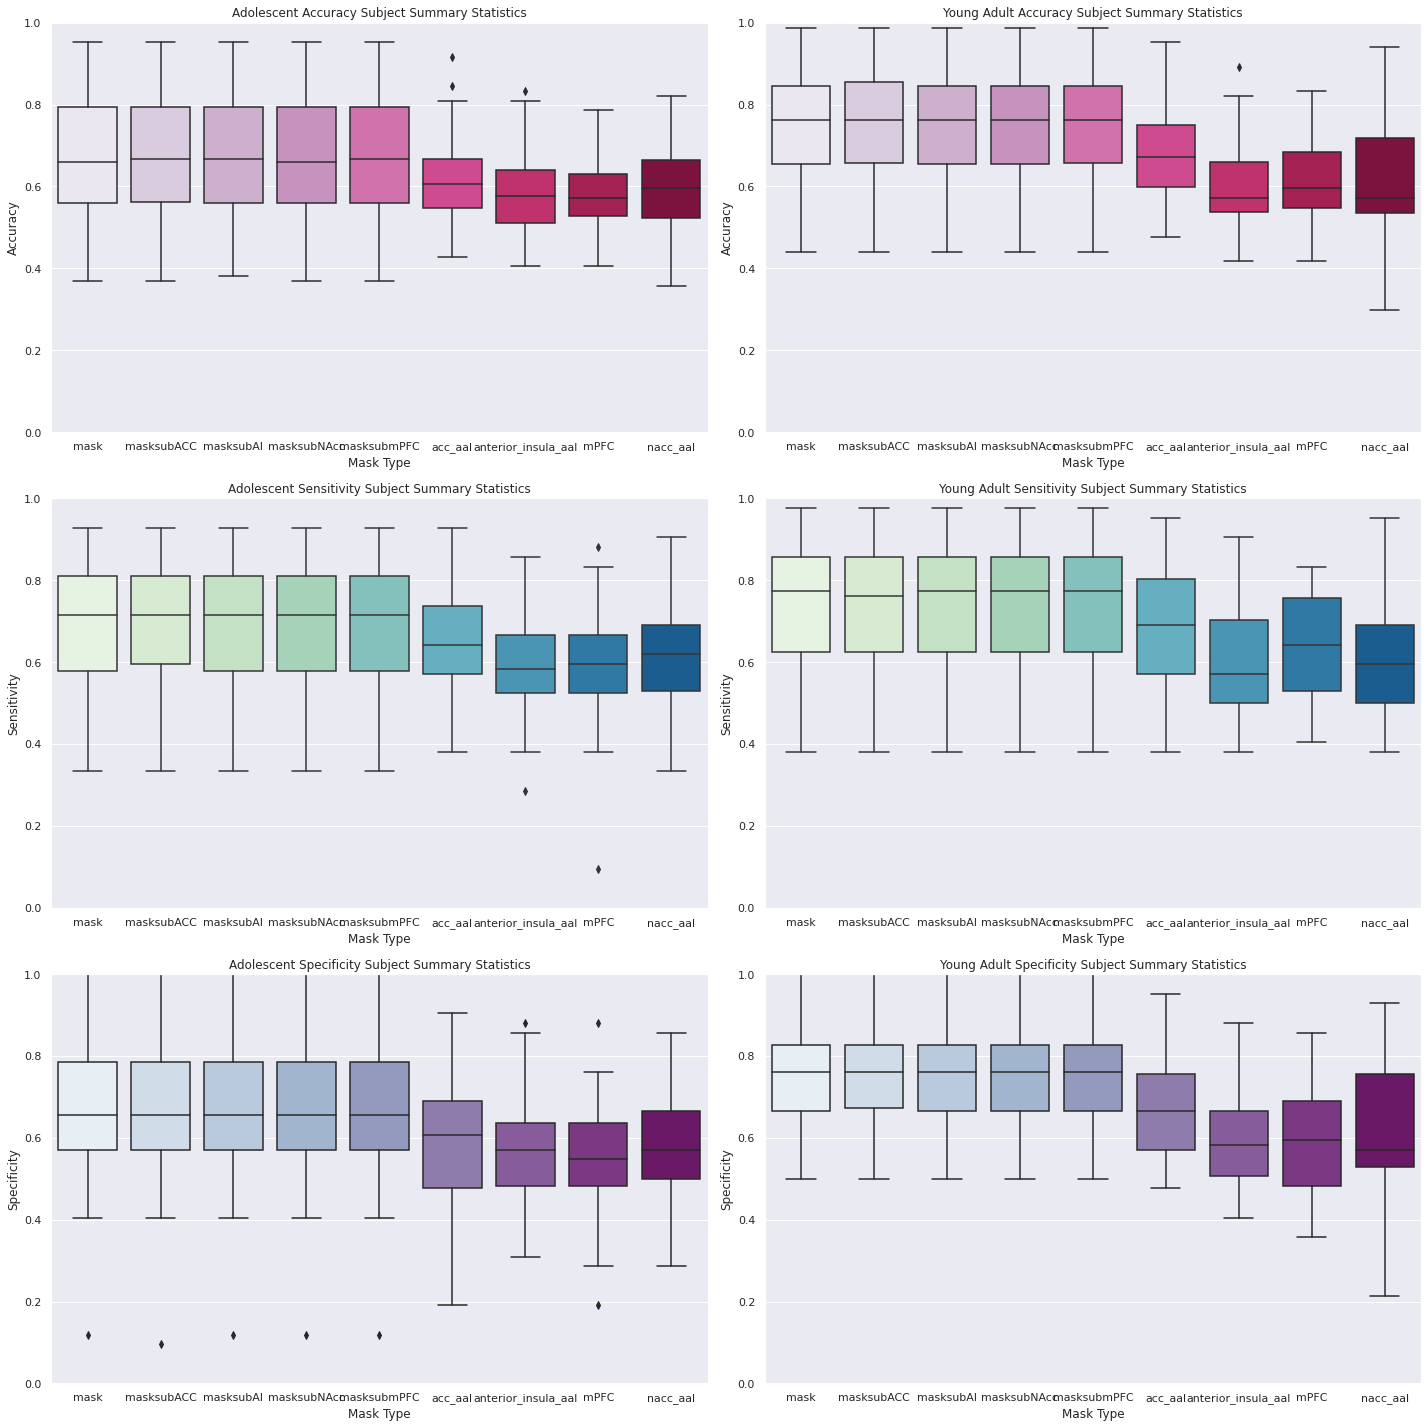

In [24]:
##create box plots accross all subjects just looking at all data
fig,axes=plt.subplots(3,2,figsize=(20,20)) #get figure size
fig.tight_layout() 
plt.style.use('seaborn-darkgrid')
sns.set(font_scale = 1)
column = 0
row = 0
runs_test = ['run_03','run_04']
metrics = [('Accuracy','PuRd'),('Sensitivity','GnBu'),('Specificity','BuPu')]
groups = ['Adolescent','Young Adult']
df = metrics_df[metrics_df['Mask Type']=='mask']
for metric,color in metrics:
  for group in groups:
    df = metrics_df[metrics_df['Group']==group]
    sns.set(font_scale = 1)
    sns.boxplot(x='Mask Type',y=metric,data=df, ax=axes[row,column],palette=color) 
    axes[row,column].set_title(f'{group} {metric} Subject Summary Statistics')
    axes[row,column].set_ylim(0,1)
    column +=1
  column = 0
  row +=1
fig.tight_layout() 
fig.savefig('/content/drive/My Drive/data/singlesubjectmodels/TR_2_TE_3_4/box_plots/boxplot_tr_2_runs3_4_group_combined.png',dpi=200)

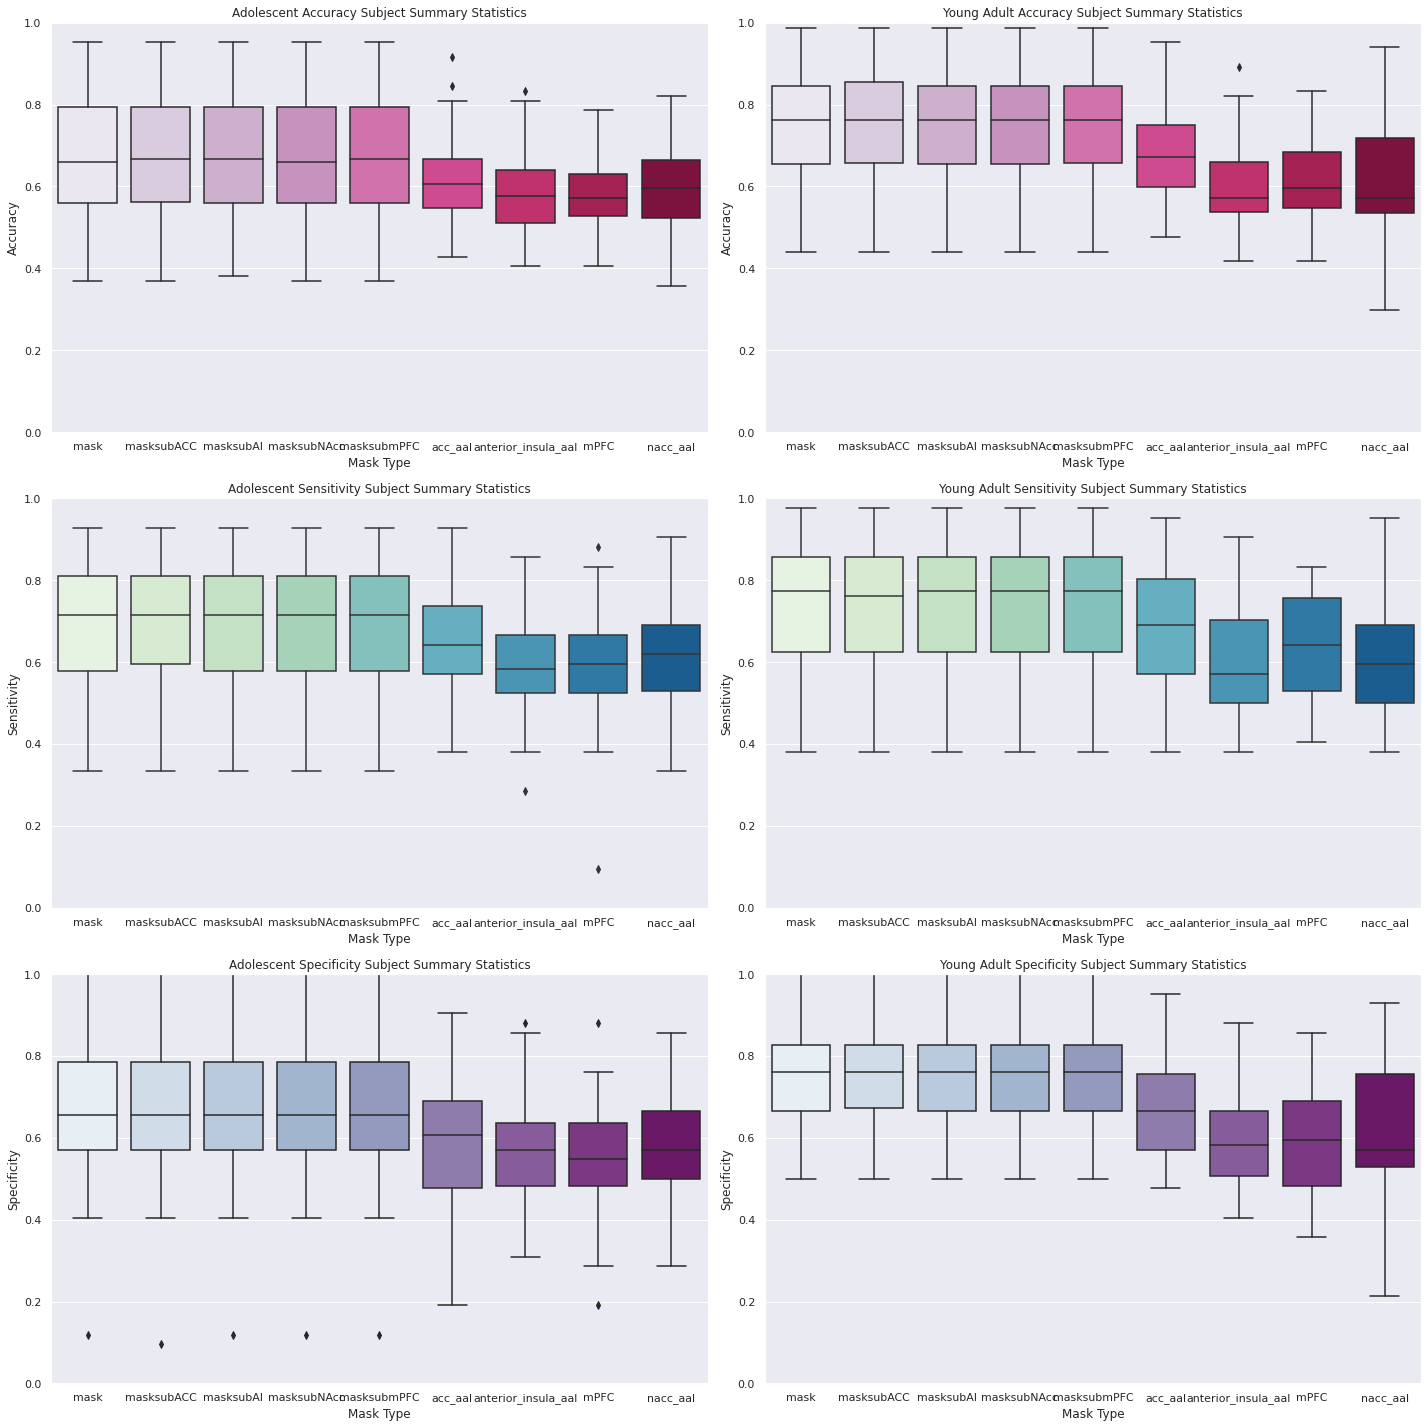

In [ ]:
##create box plots accross all subjects just looking at all data
fig,axes=plt.subplots(3,2,figsize=(20,20)) #get figure size
fig.tight_layout() 
plt.style.use('seaborn-darkgrid')
sns.set(font_scale = 1)
column = 0
row = 0
runs_test = ['run_03','run_04']
metrics = [('Accuracy','PuRd'),('Sensitivity','GnBu'),('Specificity','BuPu')]
groups = ['Adolescent','Young Adult']
df = metrics_df[metrics_df['Mask Type']=='mask']
for metric,color in metrics:
  for group in groups:
    df = metrics_df[metrics_df['Group']==group]
    sns.set(font_scale = 1)
    sns.boxplot(x='Mask Type',y=metric,data=df, ax=axes[row,column],palette=color) 
    axes[row,column].set_title(f'{group} {metric} Subject Summary Statistics')
    axes[row,column].set_ylim(0,1)
    column +=1
  column = 0
  row +=1
fig.tight_layout() 
fig.savefig('/content/drive/My Drive/data/singlesubjectmodels/TR_2_TE_3_4/box_plots/boxplot_tr_2_runs3_4_group_combined.png',dpi=200)

In [33]:
from scipy import stats
metrics_df.groupby(['Mask Type','Group']).agg({'Accuracy': ['mean','std']})
ttest_df = pd.DataFrame(columns=['Mask_Type','Mask_Compare','Group','Run','T_Test','P_value'])

In [34]:
masks_ttest_list = []
for masks in mask_list:
  masks_ttest_list.extend(masks)
print(masks_ttest_list)
for mask_ttest in masks_ttest_list:
  print(mask_ttest)
  mask_ttest_acc = metrics_df[metrics_df['Mask Type']==mask_ttest]['Accuracy']
  for mask in masks_ttest_list:
    if mask==mask_ttest:
      continue
    mask_ttest_acc2 = metrics_df[metrics_df['Mask Type']==mask]['Accuracy']
    t_stat,p_value = stats.ttest_rel(mask_ttest_acc,mask_ttest_acc2)
    ttest_df = ttest_df.append({'Mask_Type': mask_ttest,
                                'Mask_Compare': mask,
                                'Group': 'All',
                                'Run': 'Combined',
                              'T_Test': t_stat,
                              'P_value': p_value},ignore_index=True)

['mask', 'masksubACC', 'masksubAI', 'masksubNAcc', 'masksubmPFC', 'acc_aal', 'anterior_insula_aal', 'mPFC', 'nacc_aal']
mask
masksubACC
masksubAI
masksubNAcc
masksubmPFC
acc_aal
anterior_insula_aal
mPFC
nacc_aal


In [ ]:
masks_ttest_list = []
runs_test = ['run_03','run_04']
for masks in mask_list:
  masks_ttest_list.extend(masks)
print(masks_ttest_list)
for mask_ttest in masks_ttest_list:
  print(mask_ttest)
  mask_ttest_acc3 = metrics_df[(metrics_df['Mask Type']==mask_ttest) & (metrics_df['Run']=='run_03')]['Accuracy']
  mask_ttest_acc4 = metrics_df[(metrics_df['Mask Type']==mask_ttest) & (metrics_df['Run']=='run_04')]['Accuracy']

  t_stat,p_value = stats.ttest_rel(mask_ttest_acc3,mask_ttest_acc4)
  ttest_df = ttest_df.append({'Mask_Type': mask_ttest,
                              'Mask_Compare': mask_ttest,
                              'Group': 'All',
                              'Run': 'Across',
                            'T_Test': t_stat,
                            'P_value': p_value},ignore_index=True)

In [37]:
masks_ttest_list = []
groups = ['Adolescent','Young Adult']
for masks in mask_list:
  masks_ttest_list.extend(masks)
print(masks_ttest_list)
for mask_ttest in masks_ttest_list:
  print(mask_ttest)
  mask_ttest_acc_adol = metrics_df[(metrics_df['Mask Type']==mask_ttest) & (metrics_df['Group']=='Adolescent')]['Accuracy']
  mask_ttest_acc_ya = metrics_df[(metrics_df['Mask Type']==mask_ttest) & (metrics_df['Group']=='Young Adult')]['Accuracy']

  t_stat,p_value = stats.ttest_ind(mask_ttest_acc_adol,mask_ttest_acc_ya)
  ttest_df = ttest_df.append({'Mask_Type': mask_ttest,
                              'Mask_Compare': mask_ttest,
                              'Group': 'By Group',
                              'Run': 'Across',
                            'T_Test': t_stat,
                            'P_value': p_value},ignore_index=True)

['mask', 'masksubACC', 'masksubAI', 'masksubNAcc', 'masksubmPFC', 'acc_aal', 'anterior_insula_aal', 'mPFC', 'nacc_aal']
mask
masksubACC
masksubAI
masksubNAcc
masksubmPFC
acc_aal
anterior_insula_aal
mPFC
nacc_aal


In [39]:
ttest_df.to_csv('/content/drive/My Drive/data/singlesubjectmodels/TR_2_TE_3_4/summary_statistics/tr_2_te_3_4_ttest_table.csv')

In [45]:
mask_list


[['mask', 'masksubACC', 'masksubAI', 'masksubNAcc', 'masksubmPFC'],
 ['acc_aal', 'anterior_insula_aal', 'mPFC', 'nacc_aal']]

In [48]:
from sklearn import metrics
bmap_dict = {}
data_path = '/content/drive/My Drive/data/singlesubjectmodels/TR_2_TE_3_4/models/'
for mask_ind in mask_indices:
  mask_dict = get_mask_data(data_path_dict,mask_ind)
  for mask in mask_list[mask_ind]:
    data_file = f'{data_path}{mask}_tr_1_2_subject_models.pkl'
    data = open_pickle(data_file)
    bmap_dict[mask] = {}
    _, ind = make_mask(mask_dict[mask])
    subj_data = data[mask]
    for subj_id in subj_ids:
      bmap_dict[mask][subj_id] = {}
      bmap2,bmap3 = create_bmaps(subj_data[subj_id],ind,affine_image)
      bmap_dict[mask][subj_id]['bmap2'] = bmap2
      bmap_dict[mask][subj_id]['bmap3'] = bmap3
#save file
full_path_name = '/content/drive/My Drive/data/singlesubjectmodels/TR_2_TE_3_4/tr_2_te_3_4_bmaps.pkl'
filehandler = open(full_path_name,"wb")
pickle.dump(bmap_dict,filehandler)
filehandler.close()

In [49]:
bmap_dict

{'acc_aal': {'10004_08693': {'bmap2': array([0., 0., 0., ..., 0., 0., 0.]),
   'bmap3': <nibabel.nifti1.Nifti1Image at 0x7f1aff8ff790>},
  '10008_09924': {'bmap2': array([0., 0., 0., ..., 0., 0., 0.]),
   'bmap3': <nibabel.nifti1.Nifti1Image at 0x7f1affb96a10>},
  '10009_08848': {'bmap2': array([0., 0., 0., ..., 0., 0., 0.]),
   'bmap3': <nibabel.nifti1.Nifti1Image at 0x7f1b03ae3410>},
  '10016_09694': {'bmap2': array([0., 0., 0., ..., 0., 0., 0.]),
   'bmap3': <nibabel.nifti1.Nifti1Image at 0x7f1b24e83190>},
  '10017_08894': {'bmap2': array([0., 0., 0., ..., 0., 0., 0.]),
   'bmap3': <nibabel.nifti1.Nifti1Image at 0x7f1affa7a190>},
  '10018_08907': {'bmap2': array([0., 0., 0., ..., 0., 0., 0.]),
   'bmap3': <nibabel.nifti1.Nifti1Image at 0x7f1aff8ff650>},
  '10021_08839': {'bmap2': array([0., 0., 0., ..., 0., 0., 0.]),
   'bmap3': <nibabel.nifti1.Nifti1Image at 0x7f1aff7dbc90>},
  '10022_08854': {'bmap2': array([0., 0., 0., ..., 0., 0., 0.]),
   'bmap3': <nibabel.nifti1.Nifti1Image at